<font size="7">Local Field Potentials

Here we show how to analyze raw datasets.

<font color="orange">

**Sury Question**
* Do the channels from raw and spikesorted data line up?

# Set Up Notebook


import stuff

In [1]:
import matplotlib.pyplot as plt         # packages for plotting
from matplotlib.colors import Normalize
from IPython.display import display

import numpy as np         # common packages for analysis andl loading data
from scipy import signal 
from scipy.signal import correlate, correlation_lags
import pickle 

from human_hip.basics import read_phy_files,  raster_fancy_plot # our code for making plots


set some constant variables used throughout thsi notebook.
* `fs` - there are 500 datapoints per second

In [2]:
fs = 20000/40 # frame rate-- we downsampled a 20000 frames per second recording by 40
print(f"data has {fs} frames per second")

data has 500.0 frames per second


load raw data into python


In [3]:
file = open('/workspaces/human_hippocampus/data/ephys_raw/2023-04-02-e-hc328_unperturbed/raw_start0s_stop20s_downsampled40frames.pkl', 'rb')
data = pickle.load(file)
file.close()
data.shape

(1024, 10000)

Load neuron spike data into python

In [4]:
file = open('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/sd_ca1_curated.pkl', 'rb')
sd = pickle.load(file)
file.close()
sd.N


140

# <font color="blue">Helpful functions

## <font color="blue">spectrogram_plot

In [5]:
def spectrogram_plot(z, times, frequencies, coif, cmap=None, norm=Normalize(), ax=None, colorbar=True):
    ###########################################################################
    # plot
    
    # set default colormap, if none specified
    if cmap is None:
        cmap = get_cmap('Greys')
    # or if cmap is a string, get the actual object
    elif isinstance(cmap, str):
        cmap = get_cmap(cmap)

    # create the figure if needed
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()

    xx,yy = np.meshgrid(times,frequencies)
    ZZ = z
    
    im = ax.pcolor(xx,yy,ZZ, norm=norm, cmap=cmap)
    # ax.plot(times,coif)
    # ax.fill_between(times,coif, step="mid", alpha=0.4)
    
    if colorbar:
        cbaxes = inset_axes(ax, width="2%", height="90%", loc=4) 
        fig.colorbar(im, cax=cbaxes, orientation='vertical')

    ax.set_xlim(times.min(), times.max())
    ax.set_ylim(frequencies.min(), frequencies.max())

    return ax

## <font color="blue">cwt_spectrogram

In [6]:
def cwt_spectrogram(x, fs, nNotes=12, detrend=True, normalize=True):
    
    N = len(x)
    dt = 1.0 / fs
    times = np.arange(N) * dt

    ###########################################################################
    # detrend and normalize
    if detrend:
        x = signal.detrend(x,type='linear')
    if normalize:
        stddev = x.std()
        x = x / stddev

    ###########################################################################
    # Define some parameters of our wavelet analysis. 

    # maximum range of scales that makes sense
    # min = 2 ... Nyquist frequency
    # max = np.floor(N/2)

    nOctaves = int(np.log2(2*np.floor(N/2.0)))
    scales = 2**np.arange(1, nOctaves, 1.0/nNotes)
    
#     print (scales)

    ###########################################################################
    # cwt and the frequencies used. 
    # Use the complex morelet with bw=1.5 and center frequency of 1.0
    coef, freqs=pywt.cwt(x, scales, 'cmor1-1')
    frequencies = pywt.scale2frequency('cmor1-1', scales) / dt
    
    ###########################################################################
    # power
#     power = np.abs(coef)**2
    power = np.abs(coef * np.conj(coef))
    
    # smooth a bit
    power = ndimage.gaussian_filter(power, sigma=2)

    ###########################################################################
    # cone of influence in frequency for cmorxx-1.0 wavelet
    f0 = 2*np.pi
    cmor_coi = 1.0 / np.sqrt(2)
    cmor_flambda = 4*np.pi / (f0 + np.sqrt(2 + f0**2))
    # cone of influence in terms of wavelength
    coi = (N / 2 - np.abs(np.arange(0, N) - (N - 1) / 2))
    coi = cmor_flambda * cmor_coi * dt * coi
    # cone of influence in terms of frequency
    coif = 1.0/coi


    return power, times, frequencies, coif

## <font color="blue"> Downsample Dataset

Create a smaller version of the data, but only keeping 1 in 20 (by default) datapoints

In [7]:
# Downsample abd remove artifact
def downsample(wav_lfp, dec=20, fs=20000.0):
    wav_data = signal.decimate(wav_lfp, dec)
    return fs/dec, wav_data


## <font color="gray"> Artifact Removal - Never used

In [23]:
# def artifact_removal(wav_lfp):
#     corrected_lfp = sp.eeg.ATAR(wav_lfp.copy(),winsize=128*8, beta=0.1, 
#                       OptMode='elim', IPR=[25,75], k1=1, k2=10, verbose=0)[0, :]
#     return corrected_lfp

## <font color="blue"> Butter Filter

###  <font color="red"> Bad butter filter

Code copied [from here](https://github.com/hengenlab/neuraltoolkit)

In [8]:
#ntk.butter_bandpass(channel_data, highpass=hz_high, lowpass=hz_low, fs=fs, order=3)

In [25]:
# def butter_bandpass(data, highpass, lowpass, fs=20000, order=3):
#     '''
#     Butterworth bandpass filter
#     butter_bandpass(data, highpass, lowpass, fs, order=3)
#     result = butter_bandpass(data, 500, 4000, 25000, 3)
#     '''
#     nyq = 0.5 * fs
#     high_pass = highpass / nyq
#     low_pass = lowpass / nyq
#     b, a = butter(order, [high_pass, low_pass], btype='bandpass')
#     y = filtfilt(b, a, data)
#     return y

### <font color="green">Good butter filter

In [9]:
def butter_filter(data, lowcut=None, highcut=None, fs=20000.0, order=5):
    """
    A digital butterworth filter. Type is based on input value.
    Inputs:
        data: array_like data to be filtered
        lowcut: low cutoff frequency. If None or 0, highcut must be a number.
                Filter is lowpass.
        highcut: high cutoff frequency. If None, lowpass must be a non-zero number.
                 Filter is highpass.
        If lowcut and highcut are both give, this filter is bandpass.
        In this case, lowcut must be smaller than highcut.
        fs: sample rate
        order: order of the filter
    Return:
        The filtered output with the same shape as data
    """

    assert (lowcut not in [None, 0]) or (highcut != None), \
        "Need at least a low cutoff (lowcut) or high cutoff (highcut) frequency!"
    if (lowcut != None) and (highcut != None):
        assert lowcut < highcut, "lowcut must be smaller than highcut"

    if lowcut == None or lowcut == 0:
        filter_type = 'lowpass'
        Wn = highcut / fs * 2
    elif highcut == None:
        filter_type = 'highpass'
        Wn = lowcut / fs * 2
    else:
        filter_type = "bandpass"
        band = [lowcut, highcut]
        Wn = [e / fs * 2 for e in band]

    filter_coeff = signal.iirfilter(order, Wn, analog=False, btype=filter_type, output='sos')
    filtered_traces = signal.sosfiltfilt(filter_coeff, data)
    return filtered_traces

# <font color="fuchsia">Single Channel Analysis

Look at raw data from a single channel

In [10]:
data1 = data[1,:]

## <font color="fuchsia"> Initial Bandpass filtering

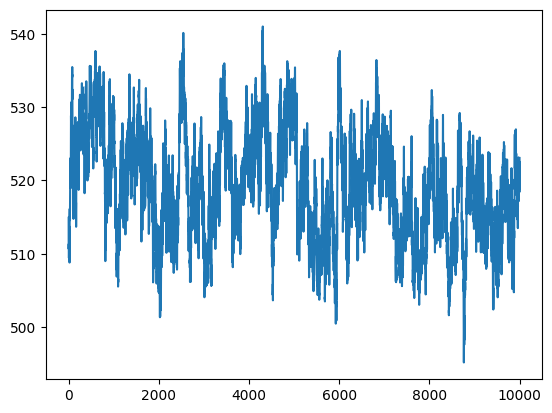

In [11]:
plt.plot( [*range(len(data1))], data1 )

In [12]:
data1_lfp = butter_filter( data1, lowcut=0.1, highcut=100, fs=fs)

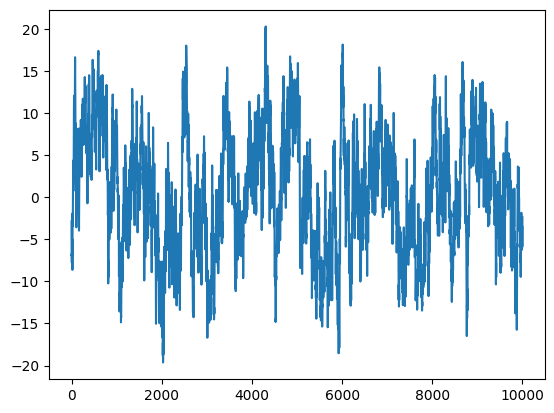

In [13]:
plt.plot( [*range(len(data1_lfp))], data1_lfp )

In [14]:
print("Data before filtering")
display(data1)
print("Data after")
display(data1_lfp)


Data before filtering


array([514.911  , 510.66205, 511.76575, ..., 520.1246 , 522.62244,
       523.0722 ], dtype=float32)

Data after


array([-2.86153618, -5.44664128, -6.80277831, ..., -5.13433821,
       -3.81468695, -2.38662778])

## <font color="fuchsia"> Plot Bands

Neuroscientists like to filter the lfp according into specific bands for analysis. Lets do that!

In [26]:
#ap_trace = butter_filter(data1_lfp, 300, 6000, fs=fs)
wav_low = butter_filter(data1_lfp, 0.1, 0.5, fs=fs)
wav_delta = butter_filter(data1_lfp, 0.5, 4, fs=fs)
wav_theta = butter_filter(data1_lfp, 4, 8, fs=fs)
wav_alpha = butter_filter(data1_lfp, 8, 13, fs=fs)
wav_beta = butter_filter(data1_lfp, 13, 30, fs=fs)
wav_gamma = butter_filter(data1_lfp, 30, 50, fs=fs)

In [17]:
subbands_data = [ data1_lfp, wav_delta, wav_theta, wav_alpha, wav_beta, wav_gamma]
subbands_names = [ "LFP [0.1, 100]", "Delta [0.5, 4]", "Theta [4, 8]", "Alpha [8, 13]", "Beta [13, 30]", "Gamma [30, 50]"]

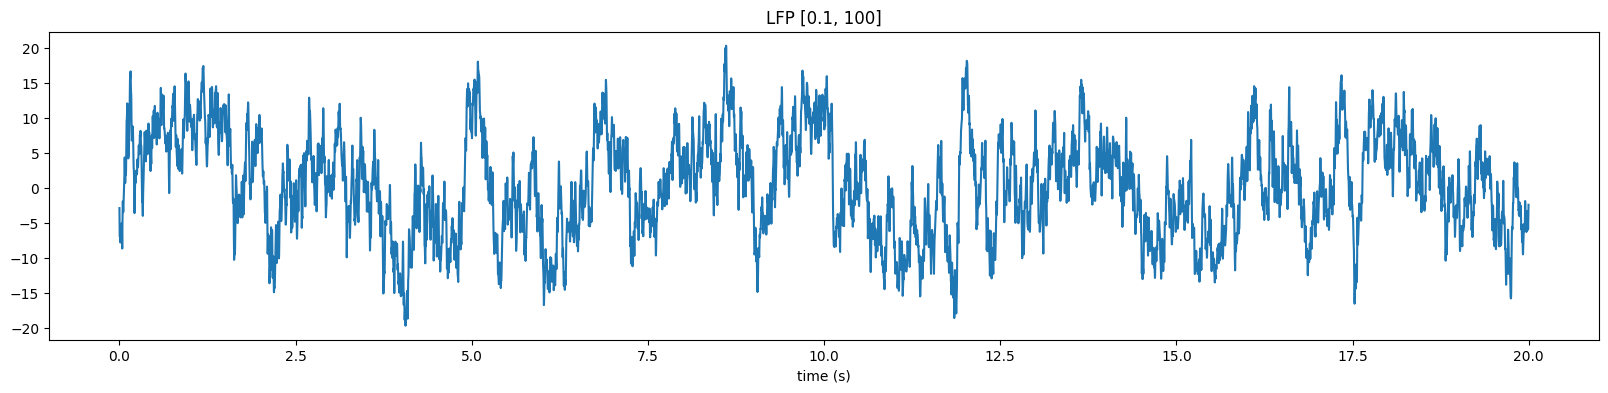

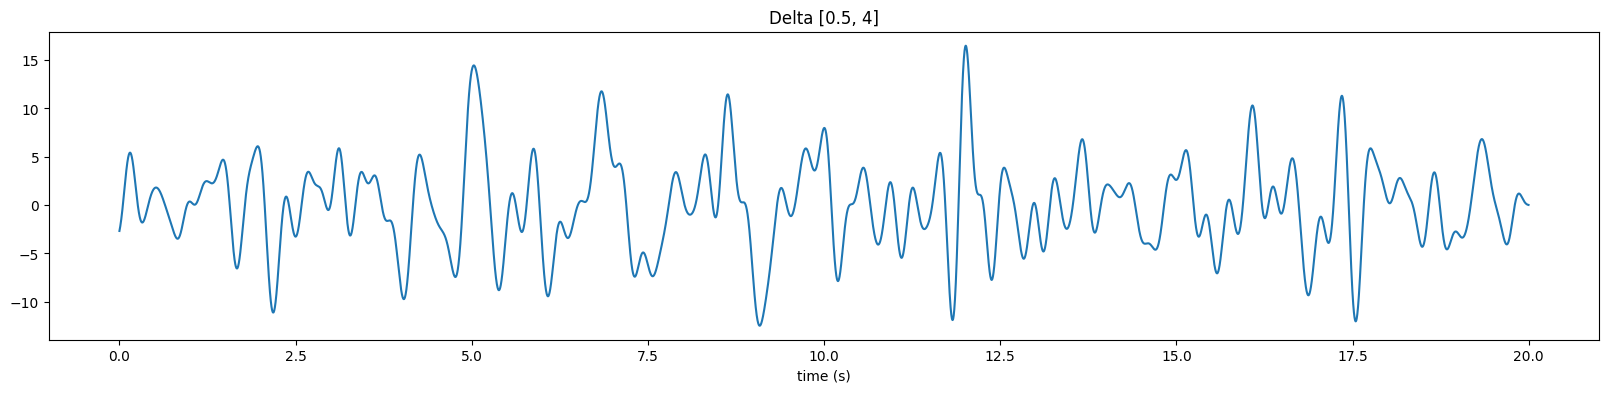

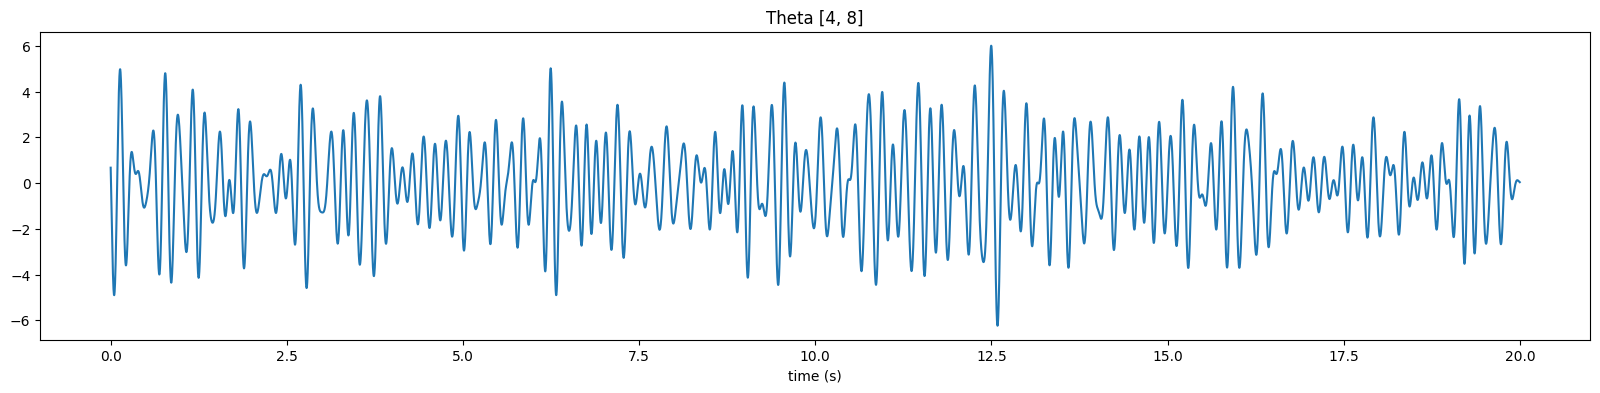

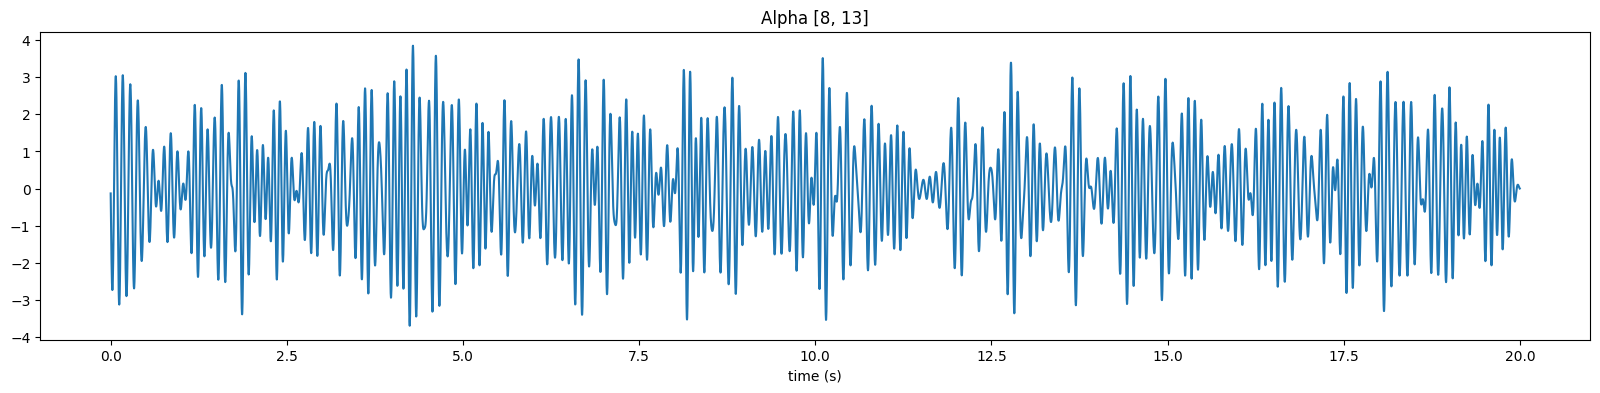

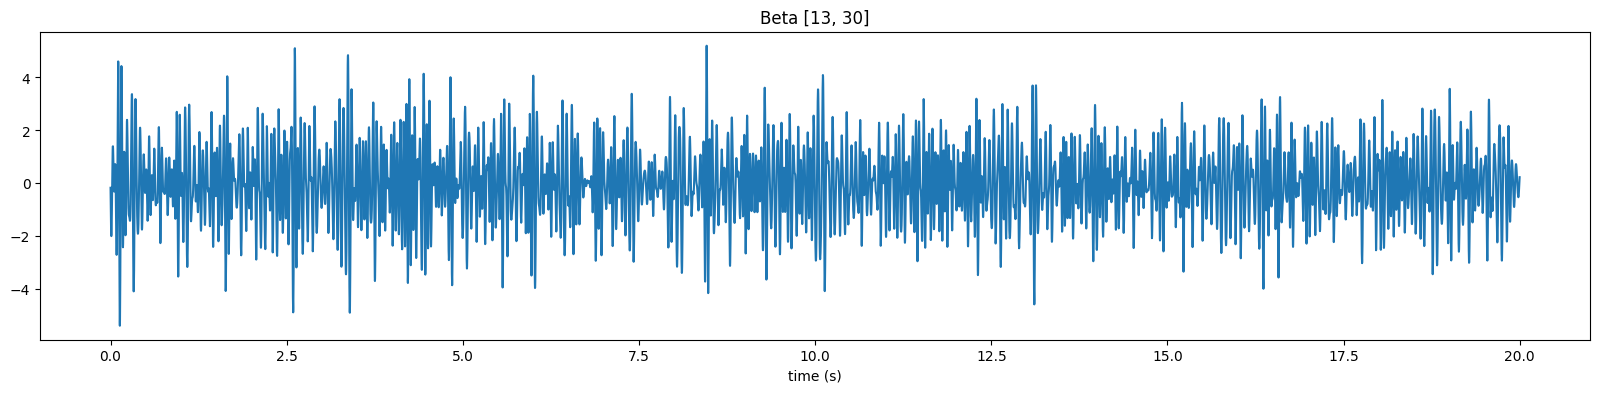

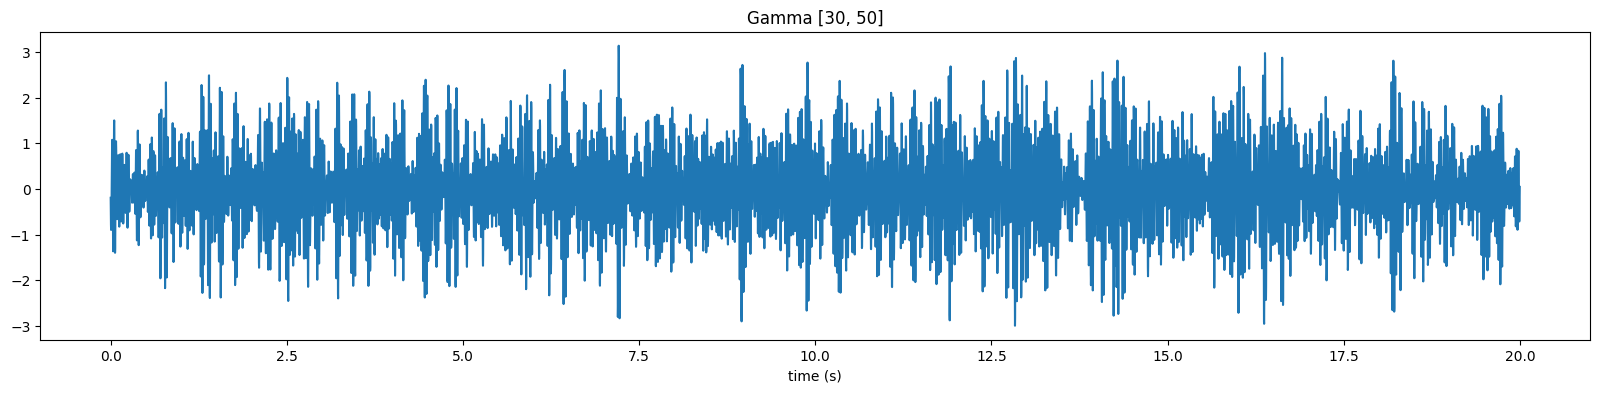

In [18]:
for i in range(len(subbands_data)):
     v
    plt.plot( np.array([*range(len(subbands_data[i]))])/fs, subbands_data[i] )
    plt.xlabel('time (s)')
    # Scale to same ylim
    plt.title(subbands_names[i])
    plt.show()

Check that adding up filters creates original plot

In [27]:
wav_reconstructed = np.zeros(len(wav_delta))
for wav_data in [ wav_low, wav_delta, wav_theta, wav_alpha, wav_beta, wav_gamma]:
    wav_reconstructed = wav_reconstructed + wav_data

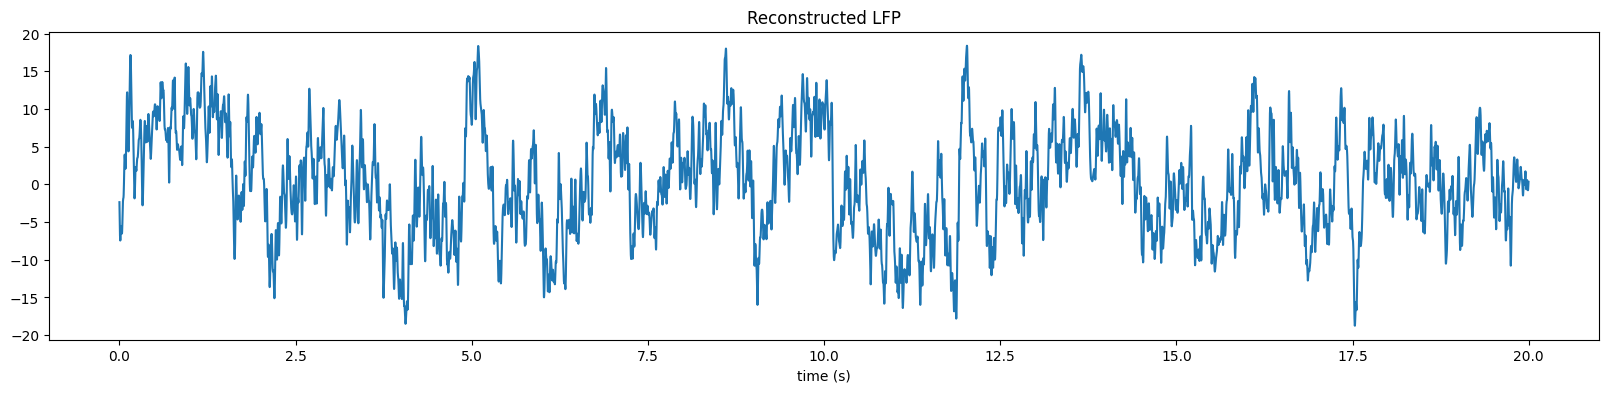

In [28]:
plt.figure(figsize=(20,4))
plt.plot( np.array([*range(len(wav_reconstructed))])/fs, wav_reconstructed )
plt.xlabel('time (s)')
# Scale to same ylim
plt.title("Reconstructed LFP")
plt.show()

<font color="red">

**To Do-** Do the fourier components recontstuct the data? 

## <font color="fuchsia"> Spectrogram... FFT? - <font color="gray"> Check with Sury

In [19]:
from braingeneers import analysis
import braingeneers.data.datasets_electrophysiology as ephys
import braingeneers.utils.smart_open_braingeneers as smart_open
import h5py
import pandas as pd
import pywt
import spkit as sp   # https://spkit.github.io/
from scipy.interpolate import interp1d
from matplotlib.cm import get_cmap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import time
from scipy import ndimage
from matplotlib.colors import Normalize, LogNorm, NoNorm


In [23]:
power, times, frequencies, coif = cwt_spectrogram(data1_lfp, fs, nNotes=12)

/tmp/ipykernel_25100/4186739557.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


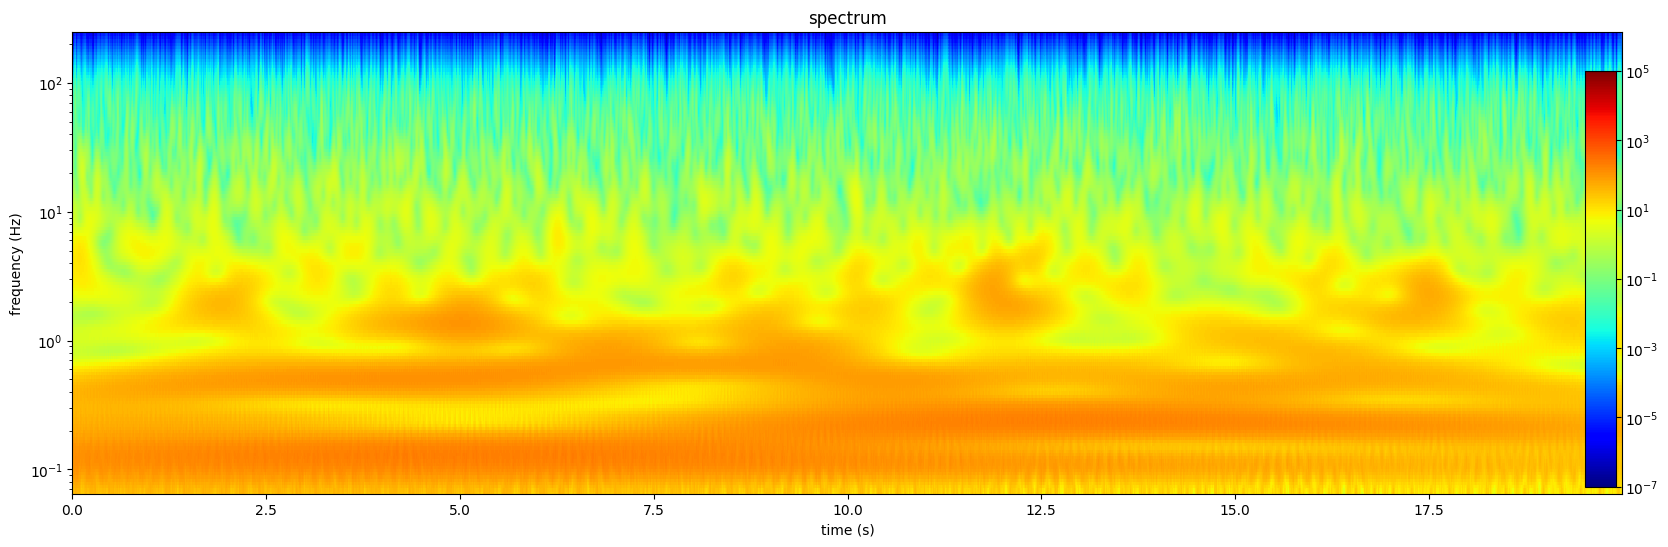

In [24]:
#print(i, channel,raw_trace.shape)
fig, axs = plt.subplots(1, 1, figsize=(20, 6))
spectrogram_plot(power, times, frequencies, coif, cmap='jet', norm=LogNorm(vmin=10e-8, vmax=10e4), ax=axs)

axs.set_title(f"spectrum", fontsize=12)
#axs.set_xlim(0, len(data1_lfp)/fs ) # code causes errors
#axs.set_ylim(0, 100)
axs.set_xlabel('time (s)')
axs.set_ylabel('frequency (Hz)')
axs.set_yscale('log')
plt.show(block=False)
#plt.savefig(f"spectrogram.png", dpi=300)
#plt.close()

# <font color="peru"> Multi-channel Analysis 

## <font color="peru">Neuron Layouts

From the raw data we spike sorted the data to find the location of active neurons. Below is a spike raster of the neurons for hte first 20 seconds

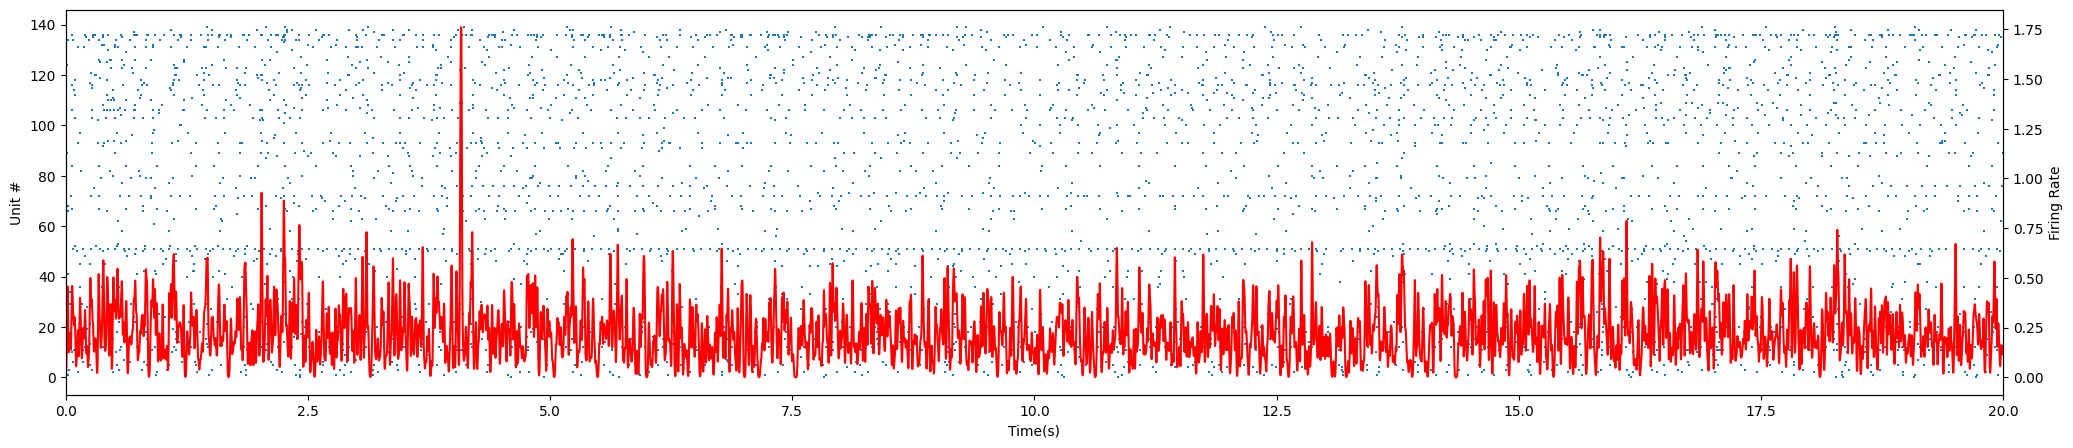

In [10]:
raster_fancy_plot(sd, xsize=25, ysize=5, start_time=0, stop_time=20)

<font color="red">

**To Do-** Notice that there's higher activity than usual around second 4. Compare the LFP's from neurons at second 4 to see if there is a pattern.

Here is view of the neurons in 2D space.

/tmp/ipykernel_2005/226950929.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():


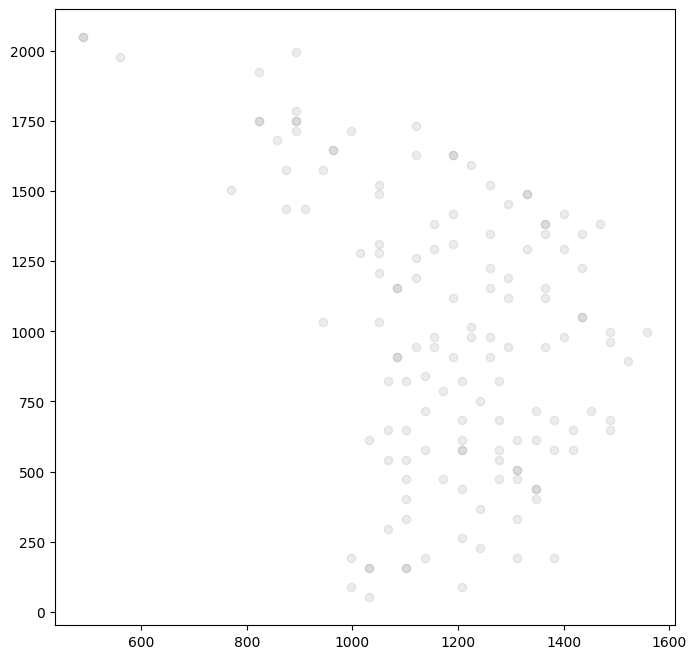

In [11]:
# Get the X/Y locations of neurons in 2D space
neuron_xy = []
for neuron in sd.neuron_data[0].values():
    neuron_xy.append( [neuron['position'][0], neuron['position'][1]] )
neuron_xy = np.array(neuron_xy)

# Plot the locations
plt.figure(figsize=(8, 8))
plt.scatter( neuron_xy[:,0], neuron_xy[:,1], alpha=0.15, c='grey')

We can also view which channel corresponds to each neurons

In [13]:
neuron_channels = []
for neuron in sd.neuron_data[0].values():
    neuron_channels.append( neuron['channel'] )
neuron_channels = np.array(neuron_channels)


/tmp/ipykernel_2005/2787768017.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():


In [14]:
neuron_channels

array([  0, 843, 155, 165, 119,  36, 240,  56, 905,  70, 175,  76,  84,
        96, 104, 704, 807, 398, 112, 953, 127, 140, 143, 154, 157, 174,
       175, 176, 219, 199, 187, 207, 212, 220,  28, 228,  36, 844, 844,
       242, 205, 245, 249,   3, 268, 224, 282, 720,  55, 714, 302, 337,
       293, 339, 400, 717, 945, 448, 491, 489, 490, 490, 501, 520, 532,
       560, 560, 564, 172, 174, 598, 795, 888, 629, 630, 652, 640, 238,
       667, 667, 679, 177, 686, 686, 692, 714, 735, 741, 756, 761, 762,
       774, 797, 273, 796, 415, 151, 816, 862, 681, 833, 836, 857, 862,
       865, 886, 322, 395, 931, 124, 944, 238, 952, 153,  33,  49, 619,
       171, 303, 140, 532, 691, 143, 864, 794, 424, 900, 266, 868, 908,
       179, 223, 900, 832, 647,  57, 211, 438, 457, 853], dtype=int32)

<font color="red">

**To Do-** Choos a a few neurons (say 10) that are reasonably close to one another. Then draw the LFP's for the 10 neurons. See if you can spot some lag in time between the LFPs. 

## <font color="peru">Cross Correlation

Previously you were asked to pick neurons that were close by to each other, and then use your eyeball to see if they had similar LFP patterns. If we happen to see similar wave patterns, with some time delay between them, then we have a fantastic discovery! How do we rigorously measure time delays between channels though? This is done using [cross corrrelation](https://en.wikipedia.org/wiki/Cross-correlation)

lets arbitrarily select the raw data from the channels for two neurons. Note, these channels probably have no particular relationship. 

<font color="red"><b>To Do</b> You need to redo this code , but with selecting channels that are close by.

In [39]:
raw_n1 = data[ neuron_channels[0],:]
raw_n2 = data[ neuron_channels[1],:]

Lets plot the data from the channels

<function matplotlib.pyplot.show(close=None, block=None)>

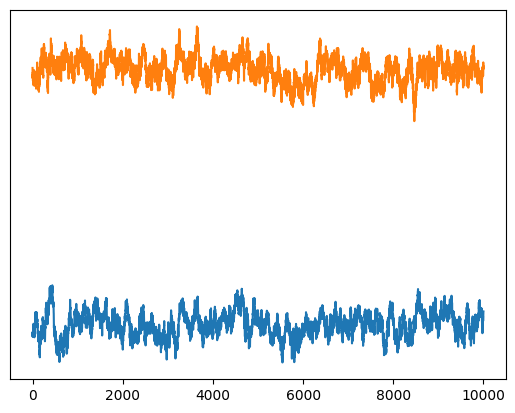

In [50]:
# This code could be useful later for creating plots of multiple data in one plot
raw_n1 = data[ neuron_channels[0],:]
raw_n2 = data[ neuron_channels[1],:]

plt.plot( [*range(len(raw_n1))], raw_n1 )
plt.plot( [*range(len(raw_n2))], raw_n2 )
plt.tick_params(left = False, bottom = True, labelleft = False ,  labelbottom = True) 
plt.show

We no calculate the cross correlation. This just mean calculating the correlation many times, while shifting the data of one of the channels through time.

In [52]:
correlations = correlate(raw_n1, raw_n2, mode="full")

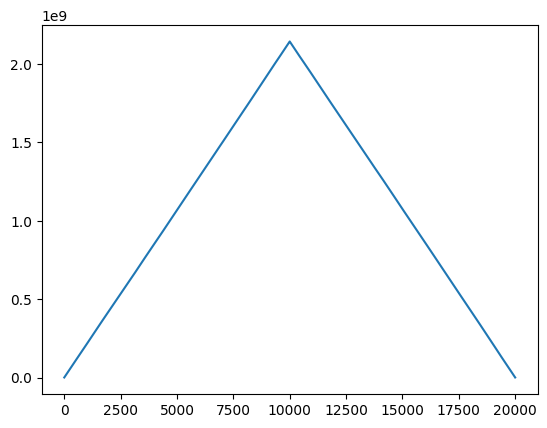

In [55]:
plt.plot( [*range(len(correlations))], correlations)


We have a function that tells us the lag time between two dataset. What this means is that it tells us at what time point the correlation is maximized. 

In [56]:
def maxCorrelationShift(x, y):
    correlations = correlate(x, y, mode="full")
    lags = correlation_lags(x.size, y.size, mode="full")
    return lags[np.argmax(correlations)]

For these two particular neruons, when looking at the raw signal, there's no time shift.

In [57]:
maxCorrelationShift(raw_n1, raw_n2)

0

<font color="red">

**To Do-**
Run this analysis, but with neurons selected from different points in space. Also, don't compare the raw signals, instead, compare signals from some of the bands commonly used in neuroscience.